## Import Libraries

In [143]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid,save_image
import torchvision.utils as vutils
from torchvision.datasets.utils import download_and_extract_archive

from matplotlib import pyplot as plt
import matplotlib.animation as animation

from typing import Callable, Optional
from IPython.display import HTML

import numpy as np

## Check GPU Availability

In [4]:
!nvidia-smi

Fri Aug 16 19:22:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0              7W /   34W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
device_num = 0

if torch.cuda.is_available():
    torch.cuda.set_device(device_num)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    device_num = -1
print(f"Using device - {device}: {device_num}")

Using device - cpu: -1


## Load DataSets

In [9]:
class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://drive.usercontent.google.com/download?id=1SlCFLq3GtDQ-LXKWNGxrvNsCkALIREgl&confirm=t&uuid=77e34988-8be5-4489-9807-6c286402cd06"

    def __init__(self, root: str, desired_class: Optional[str] = None, force_download: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        super().__init__(root=root, transform=transform, target_transform=target_transform)

        if desired_class is not None:
            self.samples = [s for s in self.samples if self.classes[s[1]] in desired_class]
            self.targets = [s[1] for s in self.samples]
            print(f"INFO: Filtered dataset to include classes: {desired_class}")

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not os.path.isfile(os.path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [16]:
img_size = 64
img_norm = dict(
    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
)

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(**img_norm),
    transforms.RandomHorizontalFlip(p=0.5),
])

In [17]:
data_root = os.path.join(".", "data")
target_class = 'Bread'
dataset = FoodImageDataset(root=data_root, desired_class=target_class, force_download=False, transform=transform)

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Filtered dataset to include classes: Bread


## DataLoader

In [18]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

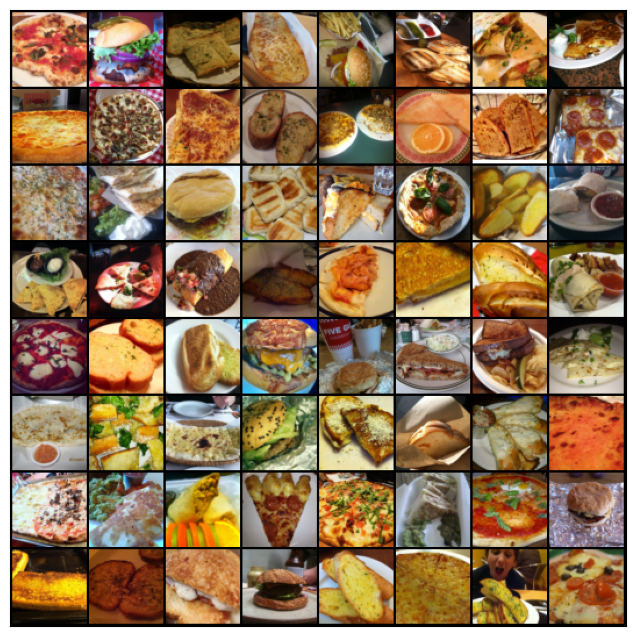

In [30]:
def denorm(img_tensors):
    return img_tensors * img_norm["mean"][0] + img_norm["std"][0]


def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
  
def show_batch(dataloader, nmax=64):
    for img, _ in dataloader:
        show_images(img, nmax)
        break
        
show_batch(dataloader)

## GAN Model Structure

In [59]:
latent_size = 128

In [133]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

In [134]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias = False),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

## Train

In [135]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [136]:
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


torch.Size([64, 3, 64, 64])


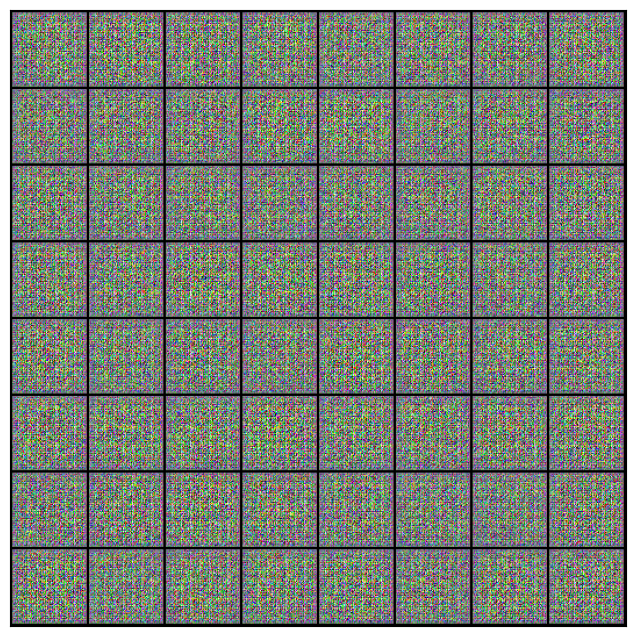

In [137]:
noise = torch.randn(batch_size, latent_size, 1, 1)
fake = netG(noise)
print(fake.shape)
show_images(fake)

In [138]:
fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

lr = 0.0002

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [144]:
num_epochs = 500

G_losses = []
D_losses = []
img_list = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        # 실제 이미지로부터의 손실 계산
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 가짜 이미지 생성 및 손실 계산
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # 실제 이미지와 가짜 이미지를 이용한 최종 손실 계산 및 Discriminator 업데이트
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # Generator를 위한 가짜 라벨은 진짜로 설정
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 학습 상태 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 손실 값 기록
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # 일정 간격마다 Generator의 결과를 고정된 노이즈로 확인 및 저장
        if (i % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

[0/500][0/22]	Loss_D: 1.0894	Loss_G: 3.9908	D(x): 0.5919	D(G(z)): 0.3974 / 0.0195


KeyboardInterrupt: 

## Result

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualization of G’s progression

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

### Real Images vs. Fake Images



In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()